1. Example why cross validation is important

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)

In [3]:
def get_prep_data():
    data = pd.read_csv('/home/mikepi/Coding/Excs/time_series_rob_mulla/time_series-xgboost/healthcare-dataset-stroke-data.csv')
    data['ever_married'] = (
        data["ever_married"].replace('Yes', True).replace('No', False))
    data['gender'] = data['gender'].astype('category')
    data['smoking_status'] = data['smoking_status'].astype('category')
    data['Residence_type'] = data['Residence_type'].astype('category')
    data['work_type'] = data['work_type'].astype('category')
    data['doctor'] = np.random.randint(0, 8, size=len(data))
    holdout_ids = data.sample(n=500, random_state=529).index
        
    train = (
        data.loc[~data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values('doctor')
        .reset_index(drop=True)
    )
        
    holdout = (
        data.loc[data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values('doctor')
        .reset_index(drop=True)
    )
    
    return train, holdout
        
train, holdout  = get_prep_data()       

In [4]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,5511,Male,66.0,0,0,True,Self-employed,Urban,71.38,NaN,formerly smoked,0,0
1,35512,Female,70.0,0,0,True,Self-employed,Rural,76.34,24.4,formerly smoked,1,0
2,20657,Female,67.0,0,0,True,Private,Urban,227.96,32.8,Unknown,0,0
3,7665,Female,73.0,0,0,True,Private,Rural,98.34,30.9,Unknown,0,0
4,66972,Female,52.0,0,0,True,Govt_job,Urban,80.88,23.8,smokes,0,0


In [5]:
train.columns


Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'doctor'],
      dtype='object')

In [6]:
def  get_X_y(train):
    
    FEATURES = [
        'gender',
        'age', 
        'hypertension', 
        'heart_disease', 
        'ever_married',
        'work_type', 
        'Residence_type', 
        'avg_glucose_level', 
        'bmi',
        'smoking_status'
    ]

    GROUPS = 'doctor'
    TARGET = 'stroke'

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    
    return X, y, groups


In [7]:
X, y, groups = get_X_y(train)
clf = lgb.LGBMClassifier(n_estimators=100)
clf.fit(X, y)
#Predict on training set
pred = clf.predict(X)
pred_proba = clf.predict_proba(X)[:, 1]

[LightGBM] [Info] Number of positive: 223, number of negative: 4387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4610, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048373 -> initscore=-2.979229
[LightGBM] [Info] Start training from score -2.979229


In [8]:
pred_proba

array([1.69561061e-01, 5.76282669e-01, 1.40300694e-02, ...,
       1.37828631e-04, 2.17667349e-04, 1.53227462e-04])

In [9]:
acc_score = accuracy_score(y, pred)
auc_score = roc_auc_score(y, pred_proba)

print(f'The score on the training set a accuracy: {acc_score:0.4f}, and AUC of {auc_score:0.4f}')

The score on the training set a accuracy: 0.9911, and AUC of 0.9997


Check on a holdout set

In [10]:
X_holdout = holdout[FEATURES]
y_holdout = holdout[TARGET]

pred = clf.predict(X_holdout)
pred_proba = clf.predict_proba(X_holdout)[:, 1]

acc_score = accuracy_score(y_holdout, pred)
auc_score = roc_auc_score(y_holdout, pred_proba)

print(f'Accuracy on holdout set is: {acc_score:0.4f}, and AUC of {auc_score:0.4f}')

NameError: name 'FEATURES' is not defined

Baseline 

Predicting all zeros

In [ ]:
accuracy_score(y, np.zeros_like(y)), roc_auc_score(y, np.zeros_like(y))

(0.9516268980477224, 0.5)

In [ ]:
X, y, groups = get_X_y(train)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

clf = lgb.LGBMClassifier(n_estimators=100, max_depth=3)
clf.fit(X_train, y_train)

pred = clf.predict(X_val)
pred_proba = clf.predict_proba(X_val)[:, 1]

acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_proba)

print(f'Our accuracy on val set is: {acc_score:0.4f}, and AUC of {auc_score:0.4f}')

[LightGBM] [Info] Number of positive: 203, number of negative: 3946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 4149, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048927 -> initscore=-2.967252
[LightGBM] [Info] Start training from score -2.967252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Cross Validation

KFold

In [14]:
kf = KFold()

In [12]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

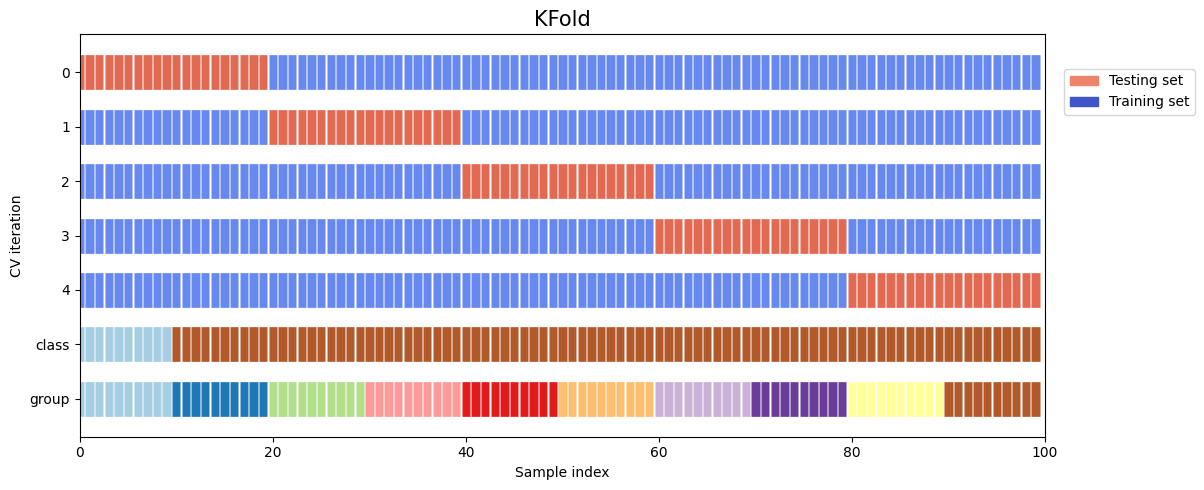

In [13]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

Stratified KFold

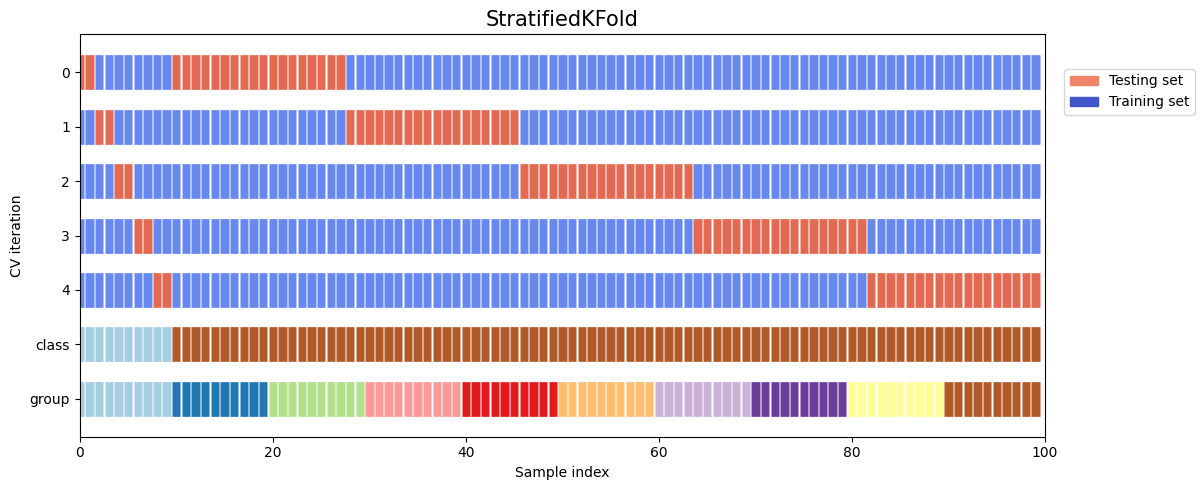

In [15]:
skf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

# Group Kfold

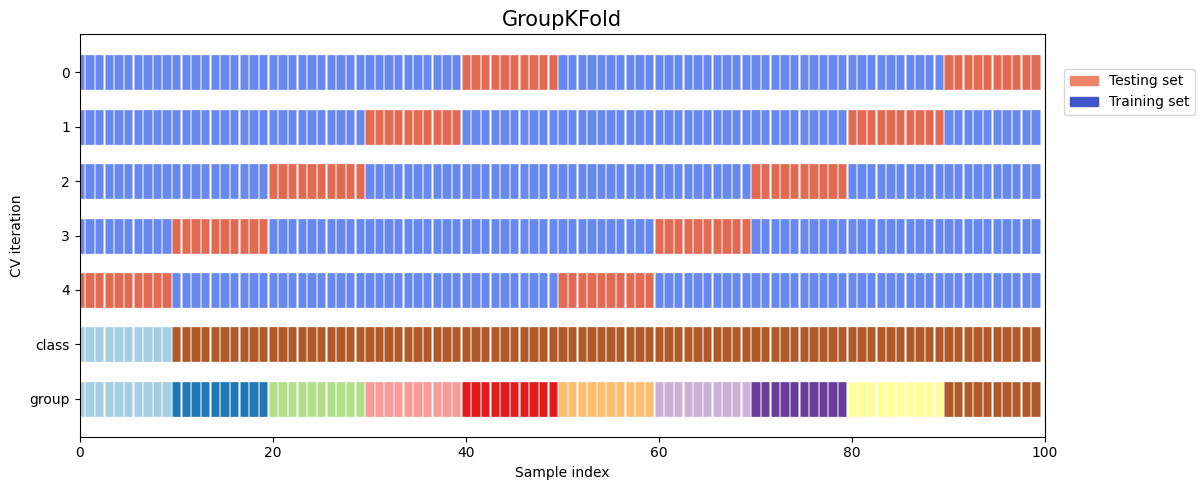

In [16]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

# Stratified Group KFold

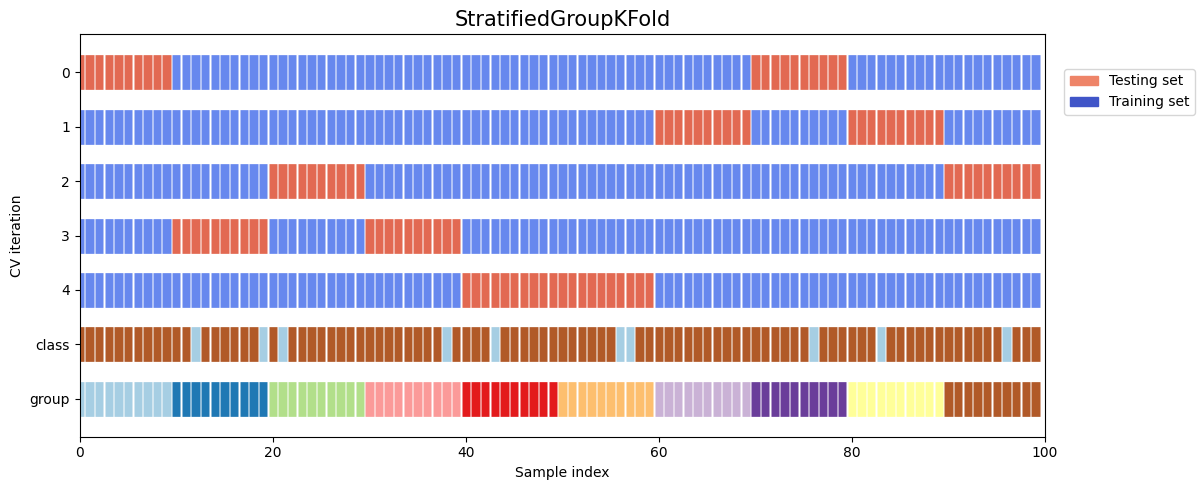

In [21]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

# Time Series Split

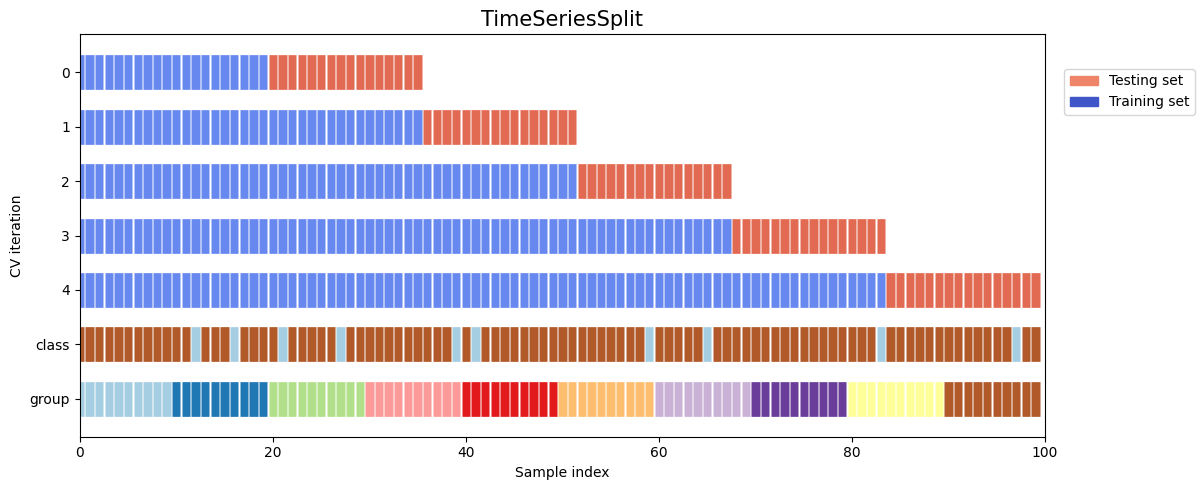

In [22]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)


# Examples
1. Small/imbalanced -> Stratified
2. Group
3. Shuffle is on

In [24]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)
X, y, groups = get_X_y(train)

for train_idx, val_idx in sgk.split(X, y, groups):
    break


In [25]:
train_idx

array([   0,    1,    2, ..., 4032, 4033, 4034])

In [27]:
val_idx

array([ 552,  553,  554, ..., 4607, 4608, 4609])